In [1]:
from concurrent.futures import as_completed, ThreadPoolExecutor
import random
from typing import Dict

import equinox as eqx
import hydra
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from omegaconf import DictConfig, OmegaConf
import seaborn as sns
from tqdm import tqdm

from phd.feature_search.scripts.jax_full_feature_search import train_step, train_multi_step, run_experiment, TrainState
from phd.feature_search.jax_core.experiment_helpers import prepare_components, rng_from_string, seed_from_string
from phd.feature_search.jax_core.models import MLP
from phd.feature_search.jax_core.tasks.geoff import NonlinearGEOFFTask

%matplotlib inline

if not hydra.core.global_hydra.GlobalHydra().is_initialized():
    hydra.initialize(config_path='../conf')

/home/edan/local_projects/phd_research/phd/feature_search/scripts/jax_full_feature_search.py:430: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='../conf', config_name='full_feature_search')
/tmp/ipykernel_67484/3438910553.py:22: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path='../conf')


In [2]:
def prepare_experiment(cfg):
    task, model, criterion, optimizer, repr_optimizer, cbp_tracker = \
        prepare_components(cfg)
    
    if cfg.seed is not None:
        rng = jax.random.key(cfg.seed)
    else:
        rng = jax.random.key(random.randint(0, 2**31))

    task_init_key = rng_from_string(rng, 'task_init_key')
    task.weights[-1] = jax.random.uniform(
        task_init_key,
        task.weights[-1].shape,
        minval = -jnp.sqrt(6 / task.weights[-1].shape[0]),
        maxval = jnp.sqrt(6 / task.weights[-1].shape[0]),
    )
    model = eqx.tree_at(
        lambda m: m.layers[-1].weight, model,
        jnp.zeros_like(model.layers[-1].weight),
    )
    return task, model, criterion, optimizer, repr_optimizer, cbp_tracker, rng


def prepare_and_run_experiment(cfg, show_progress: bool = True):
    task, model, criterion, optimizer, repr_optimizer, cbp_tracker, rng = \
        prepare_experiment(cfg)
    
    jax.config.update('jax_compilation_cache_dir', cfg.jax_jit_cache_dir)
    jax.config.update('jax_persistent_cache_min_entry_size_bytes', -1)
    jax.config.update('jax_persistent_cache_min_compile_time_secs', 0.1)
    jax.config.update('jax_persistent_cache_enable_xla_caches', 'xla_gpu_per_fusion_autotune_cache_dir')
    
    metrics = run_experiment(
        cfg, task, model, criterion, optimizer,
        repr_optimizer, cbp_tracker, None, rng,
        show_progress = show_progress,
    )
    
    return metrics

In [3]:
def set_cfg_val(cfg, param_path, val):
    path = param_path.split('.')
    sub_cfg = cfg
    for p in path[:-1]:
        sub_cfg = sub_cfg.get(p)
    sub_cfg[path[-1]] = val
    return cfg


# Note that this does not take a cartesian product of the sweep params
def create_sweep_configs(base_cfg: DictConfig, sweep_params: Dict, n_seeds: int):
    sweep_configs = []
    base_seed = base_cfg.seed if base_cfg.seed is not None else random.randint(0, 2**30)
    for seed in range(base_seed, base_seed + n_seeds):
        seed_cfg = base_cfg.copy()
        seed_cfg.seed = seed
        for param_path, vals in sweep_params.items():
            for val in vals:
                cfg = seed_cfg.copy()
                cfg = set_cfg_val(cfg, param_path, val)
                sweep_configs.append(cfg)
    return sweep_configs


def run_sweep(base_cfg: DictConfig, sweep_params: Dict, n_seeds: int, n_threads: int):
    sweep_configs = create_sweep_configs(base_cfg, sweep_params, n_seeds)
    total = len(sweep_configs)
    results = []
    # Use threading instead of multiprocessing to avoid JAX fork issues
    with ThreadPoolExecutor(max_workers=n_threads) as executor:
        futures = []
        for cfg in sweep_configs:
            futures.append(executor.submit(prepare_and_run_experiment, cfg, False))
        
        for future in tqdm(as_completed(futures), total=total, desc="Running experiments"):
            results.append(future.result())
    return results

In [4]:
experiment_base_cfg = DictConfig(dict(
    task = {
        'name': 'nonlinear_geoff',
        'n_features': 128,
        'n_real_features': '${task.n_features}',
        'flip_rate': 0.0,
        'n_layers': 4,
        'n_stationary_layers': 4,
        'hidden_dim': 128,
        'activation': 'ltu',
        'sparsity': 0.99,
        'weight_init': 'binary',
        'noise_std': 0.0,
    },
    train = {
        'batch_size': 1,
        'total_steps': 300_000,
        'standardize_cumulants': True,
        'log_freq': 1000,
    },
    feature_recycling = {
        'use_cbp_utility': True,
        'use_signed_utility': False,
        'recycle_rate': 0.0,
        'utility_decay': 0.99,
        'feature_protection_steps': 100,
        'prune_frequency': 4,
    },
    model = {
        'output_dim': 1,
        'n_layers': 3,
        'hidden_dim': 128,
        'weight_init_method': 'lecun_uniform', # Input layer only
        'activation': 'ltu',
        'n_frozen_layers': 0,
        'use_bias': True,
    },
    optimizer = {
        'name': 'rmsprop',
        'learning_rate': 0.001,
    },
))

# Load hydra config
default_cfg = hydra.compose(config_name='nonlinear_geoff')
cfg = OmegaConf.merge(default_cfg, experiment_base_cfg)

/home/edan/miniconda3/envs/jax/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'nonlinear_geoff': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


### Step-size sweep

In [ ]:
step_sizes = jnp.array([2**i for i in range(-6, -17, -1)]).tolist()

results = run_sweep(
    cfg,
    sweep_params = {
        'optimizer.learning_rate': step_sizes,
    },
    n_seeds = 3,
    n_threads = 4,
)

Running experiments:   0%|          | 0/33 [00:00<?, ?it/s]

dict_keys(['baseline_loss', 'cumulative_loss', 'loss', 'samples', 'squared_targets', 'step'])


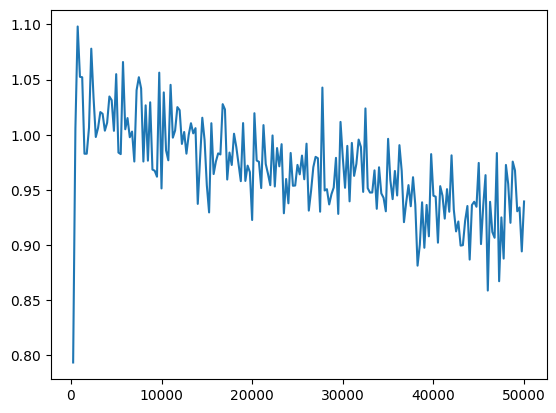

In [13]:
print(metrics.keys())
step = metrics['samples']
losses = metrics['loss']
plt.plot(step, losses)